In [1]:
#EDA
#packages
import warnings
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import datetime as dt

import plotly.express as px
import plotly.graph_objects as go
import plotly.colors

%matplotlib inline

In [2]:
%run -i "path.ipynb"
path=ipath+"\KPMG_VI_merged.xlsx"

warnings.filterwarnings('ignore')
merged=pd.read_excel(path, sheet_name='MergedDataset')
merged.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,profit
0,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,2005-05-10,110.56
1,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,1,Approved,Solex,Standard,medium,medium,1577.53,826.51,2008-03-19,751.02
2,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,1,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-21,189.28
3,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,0,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,2003-09-09,90.10
4,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-09,17.87


In [ ]:
merged.columns

In [ ]:
merged.info()

In [ ]:
merged.shape

# univariate analysis on price columns and past_3_years_bike_related_purchases to check for any outliers

In [ ]:
def num_plot(df,col,title):
    fig,ax=plt.subplots()
    sn.distplot(df[col],ax=ax)
    ax.set(title=title)
    ax.axvline(x=df[col].mean(), color='b', label='Mean')
    ax.axvline(x=df[col].median(), color='g', label='Median')
    ax.axvline(x=df[col].mode()[0], color='r', label='Mode')
    ax.legend()
    print("{} mean: {}".format(col, df[col].mean()))
    print("{} median: {}".format(col, df[col].median()))
    print("{} mode: {}".format(col, df[col].mode()[0]))

In [ ]:
num_plot(merged,'list_price','List Price Distribution')

In [ ]:
#list price looks uniformly distributed with mean 1107

In [ ]:
num_plot(merged,'standard_cost','Standard Cost Distribution')

In [ ]:
#standard cost is right skewed showing outliers from 1500 to 2000 .
#Mean is affected by the skewness and mode is can be considered for this column

In [ ]:
num_plot(merged,'profit','Profit Distribution')

In [ ]:
#profit is also right skewed, but there are no outliers seen in profit. It shows that the outiers in cost doesn't affect the over all skewness of Financial status

# RFM Analysis
Recency(Recent purchases)
Frequency(number of frequent purchases done)
Monetary (How much profit have they given the company)

In [ ]:
merged['transaction_date'].min(),merged['transaction_date'].max()

In [3]:
lastdt = max(merged['transaction_date']) + dt.timedelta(days=1)
lastdt

Timestamp('2017-12-31 00:00:00')

In [4]:
rfm=merged.groupby('customer_id').agg(
    recency=('transaction_date', lambda dt: (lastdt-dt.max()).days),
    frequency=('transaction_id', 'count'),
    monetary=('profit', 'sum')
).reset_index()
rfm.head()

,customer_id,recency,frequency,monetary
0,1,8,11,3018.09
1,2,129,3,2226.26
2,4,196,2,220.57
3,5,17,6,2394.94
4,6,65,5,3946.55


In [5]:
#Defining scoring criteria for each RFM value
rfm['r_score'] = pd.qcut(rfm['recency'], 5, ['1','2','3','4','5'])
rfm['f_score'] = pd.qcut(rfm['frequency'], 5, ['5','4','3','2','1'])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, ['5','4','3','2','1'])

#Converting RFM scores to numeric type
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

In [6]:
#calculating RFM class by concatenating the score of each r,f,m & calculating the RFM score by summing the r,f,m segments
rfm['RFMscore'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)
rfm['RFMsum']= rfm[['r_score','f_score','m_score']].sum(axis=1)
rfm.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,RFMscore,RFMsum
0,1,8,11,3018.09,1,1,3,113,5
1,2,129,3,2226.26,5,5,4,554,14
2,4,196,2,220.57,5,5,5,555,15
3,5,17,6,2394.94,2,3,4,234,9
4,6,65,5,3946.55,4,4,2,442,10


In [69]:
#segmenting customer type

seg_map = {
    r'[4-5][4-5][4-5]':'Platinum Customer',
    r'[3-5][3-5][3-5]': 'Loyal Customers',
    r'[3-5][2-5][2-5]': 'Potential Loyal',
    r'[1-2][4-5][4-5]': 'Cannot lose',
    r'[3-5][1-5][1-5]': 'Potential Customer',
    r'[4-5][1-2][1-2]': 'New Customers',
    r'1[1-5][1-2]':'Lost Customer',
    r'[1-2][1-3][1-3]' : 'Hibernating Customers',
    r'[1-2][1-5][1-5]': 'At Risk Customer'
    
}


In [70]:
rfm['Customer_type']=rfm['RFMscore']
rfm['Customer_type'] = rfm['Customer_type'].replace(seg_map, regex=True)
rfm.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,RFMscore,RFMsum,Customer_type
0,1,8,11,3018.09,1,1,3,113,5,Hibernating Customers
1,2,129,3,2226.26,5,5,4,554,14,Platinum Customer
2,4,196,2,220.57,5,5,5,555,15,Platinum Customer
3,5,17,6,2394.94,2,3,4,234,9,At Risk Customer
4,6,65,5,3946.55,4,4,2,442,10,Potential Loyal


In [72]:
rfm['Customer_type'].value_counts()

Platinum Customer        617
Loyal Customers          609
Potential Customer       462
Hibernating Customers    417
Potential Loyal          393
Lost Customer            358
Cannot lose              332
At Risk Customer         297
Name: Customer_type, dtype: int64

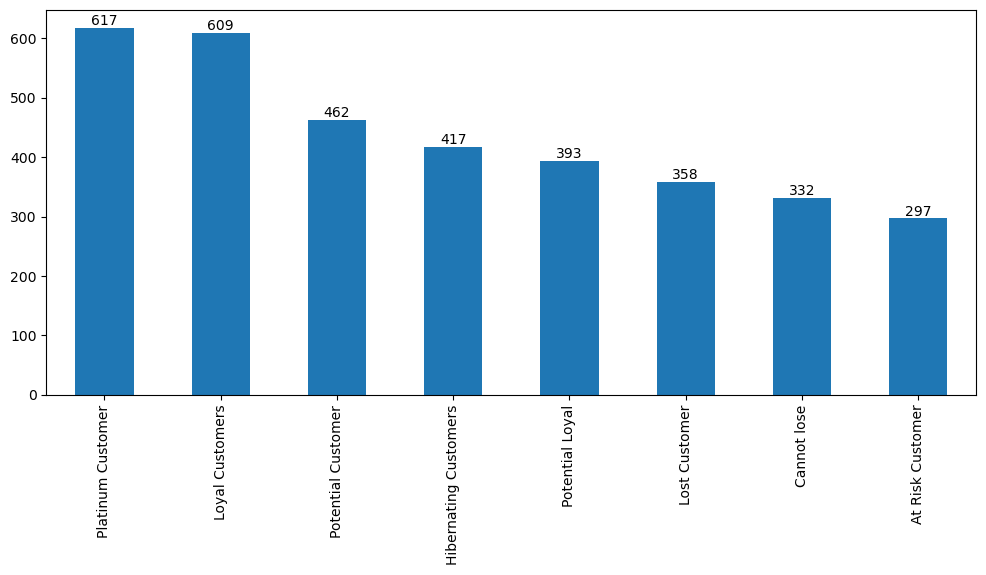

In [91]:
plt.figure(figsize=(12,5))
ax=rfm['Customer_type'].value_counts().plot.bar()
for i in ax.containers:
    ax.bar_label(i)

array([<Axes: ylabel='Customer_type'>], dtype=object)

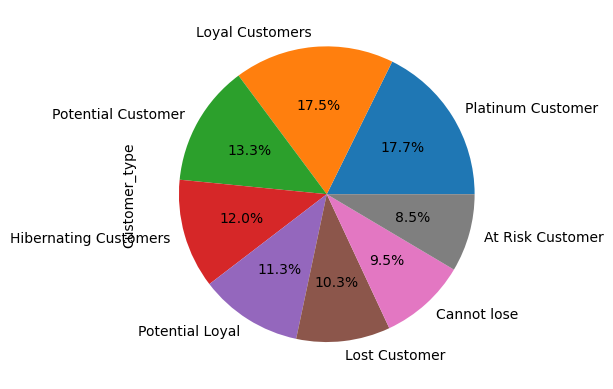

In [83]:
rfm['Customer_type'].value_counts().plot.pie(subplots=True, autopct='%1.1f%%')


In [93]:
merged_rfm=merged.merge(rfm, on='customer_id')
merged_rfm.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,profit,recency,frequency,monetary,r_score,f_score,m_score,RFMscore,RFMsum,Customer_type
0,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,110.56,8,11,3018.09,1,1,3,113,5,Hibernating Customers
1,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,751.02,8,11,3018.09,1,1,3,113,5,Hibernating Customers
2,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,189.28,8,11,3018.09,1,1,3,113,5,Hibernating Customers
3,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,90.10,8,11,3018.09,1,1,3,113,5,Hibernating Customers
4,1,Laraine,Medendorp,F,93,Executive Secretary,Health,Mass Customer,N,Yes,...,17.87,8,11,3018.09,1,1,3,113,5,Hibernating Customers


In [97]:
merged_rfm.shape

(19400, 40)

In [98]:
#transferring resulting dataframe to csv file for next step
merged_rfm.to_csv(ipath+"\\merged_rfm.csv")